## Import Libs

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Import Option Chain

In [38]:
# collect option chain from your broker, only bid/ask and spot price are needed.
chain = pd.read_csv(r'E:\Data\Canmet\market\chain.csv')
# price of put and call contracts as average of bid/ask price:
chain['call'] = chain['Bid_c']/2 + chain['Ask_c']/2
chain['put'] = chain['Bid_p']/2 + chain['Ask_p']/2
chain.head()

,Open Int_c,Volume_c,Last Price_c,Change_c,Bid_c,Ask_c,STRIKE,Bid_p,Ask_p,Last Price_p,Change_p,Volume_p,Open Int_p,call,put
0,34,0,12.00,0.0,7.25,7.50,20.0,0.00,0.02,0.01,0.0,0,10,7.375,0.010
1,51,0,11.30,0.0,6.75,7.00,20.5,0.01,0.02,0.03,0.0,0,51,6.875,0.015
2,9,0,9.80,0.0,6.25,6.50,21.0,0.01,0.03,0.05,0.0,0,50,6.375,0.020
3,26,0,9.95,0.0,5.75,6.05,21.5,0.03,0.04,0.07,0.0,0,70,5.900,0.035
4,53,0,10.05,0.0,5.30,5.50,22.0,0.05,0.07,0.06,0.0,0,55,5.400,0.060


### Calculate Extrinsic Value and Plot put/call Parity

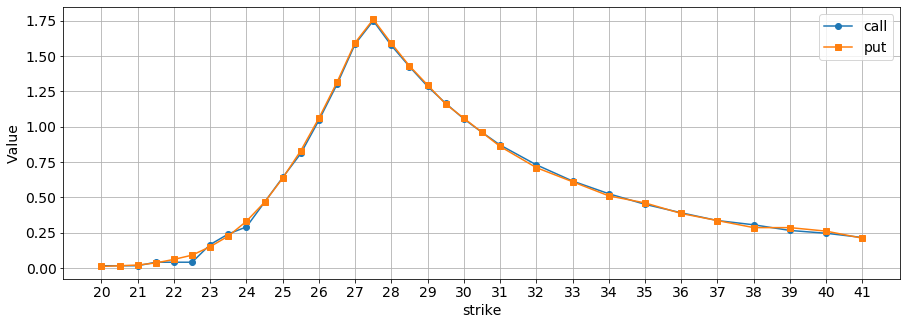

In [39]:
#inter spot price:
spot = 27.36

#calculate the extrinsic (time value) for each contract in the chain:
call_premiums = []
put_premiums = []
for i in range(len(chain)):
    if chain.STRIKE[i] < spot:
        call_premium = chain.call[i] - (spot - chain.STRIKE[i])
        if call_premium < 0: # it could be slightly less than 0 because average of bid/ask price could be skewed toward bid
            call_premium = 0
        call_premiums.append(round(call_premium, 3))
        put_premiums.append(round(chain.put[i],3))
    else:
        call_premiums.append(round(chain.call[i],3))
        put_premium = chain.put[i] + (spot - chain.STRIKE[i])
        if put_premium < 0:
            put_premium = 0 # it could be slightly less than 0 because average of bid/ask price could be skewed toward bid
        put_premiums.append(round(put_premium, 3))

plt.xlabel('strike')
plt.ylabel('Value')
plt.plot(chain.STRIKE, call_premiums, label = 'call', marker = 'o')
plt.plot(chain.STRIKE, put_premiums, label = 'put', marker = 's')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams.update({'font.size': 14})
plt.xticks(np.arange(min(chain.STRIKE), max(chain.STRIKE)+1, 1.0))
plt.legend()
plt.grid(which = 'major')
plt.show()

### Finding the Ratio of Maximum_Reward/Maximum_Risk

   strike_1  strike_2  RS_RW
0      27.0      28.0   0.57
1      27.0      28.5   0.54
2      26.5      29.0   0.54
3      27.5      28.0   0.52
4      26.5      29.5   0.51
5      27.0      29.0   0.49
6      27.5      28.5   0.49
7      26.0      30.5   0.48
8      26.5      30.0   0.47
9      27.0      29.5   0.47


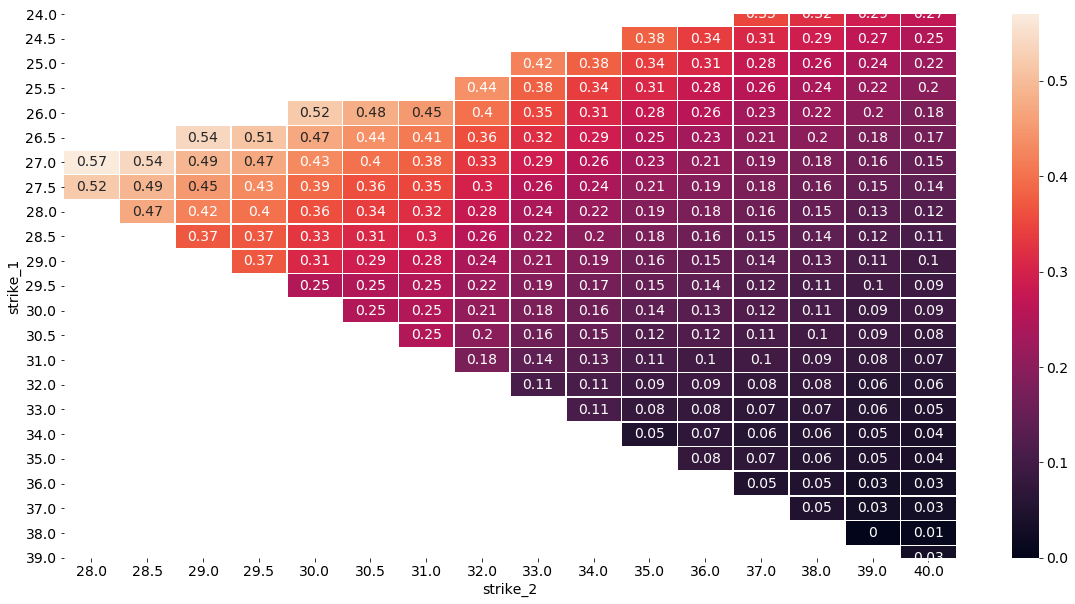

In [43]:
# this code finds the sweat spot for bearish (short) sentiment: buying put spread or selling call spread. 
# for long (bullish) you need to reverse the process for strike 1 and strike 2. 

df = pd.DataFrame({'call': call_premiums,'put': put_premiums})
df['strike']= chain.STRIKE
minimum_extrinsic_value = 0.05 # filter out extreme OTM options, larger  values => more OTMs filtered, 0 includes all.
df = df[( df.call > minimum_extrinsic_value) & (df.put  > minimum_extrinsic_value)]
df.reset_index( inplace = True, drop = True)

S1 = []   #strike 1, you short this stike
SP_1 = [] #put price for strike 1
S2 = []   #strike 2, you long this strike
SP_2 = [] #put price for strike 2
RW = []   #Max Reward attainable for buying the put spread 
RS = []   #Max Risk (loss) for buying the put spread
RS_RW = []#list of all possible reward/risk ratios

time_decay_value = 0.0 # possible spreads in option chain are filtered based on this value  
         # this is the maximum $ value you are OK to pay for the extrinsic value of the spread 
         # positive value means time favors your spread, a negative value time against your spread, 0 neutral
         # buying put spread or selling call spreads, the higher you bearish, you are OK with higher time_decay_value

#this loop finds the ratio of max_reward/max_risk for all spreads that satisfies your condition for time_decay_value:
for i in range(len(df)-1):
    for j in range(i+1,(len(df)-1)):
        if df.put[i]-df.put[j] > time_decay_value:
            if df.strike[i] > spot:
                rw = (df.put[i]-df.put[j])
                rs = (df.strike[j] - df.strike[i]) - rw # take care of commision
            elif df.strike[i] < spot and df.strike[j] > spot:
                rw = (df.put[i]-df.put[j]) + (spot - df.strike[i])#-0.25
                rs = (df.strike[j] - df.strike[i]) - rw
            else:
                rw = (df.strike[j] - df.strike[i]) + (df.put[i]-df.put[j])
                rs = -(df.put[i]-df.put[j])
            S1.append(df.strike[i])
            SP_1.append(df.put[i])
            S2.append(df.strike[j])
            SP_2.append(df.put[j])
            RW.append(round(rw, 2))
            RS.append(round(rs, 2))
            r_s = round((rw)/(rs), 2)
            RS_RW.append(r_s)

#generate table:
put_df = pd.DataFrame({'strike_1': S1, 'SP_1': SP_1, 'strike_2': S2, 'SP_2':SP_2,  'RW': RW, 'RS': RS, 'RS_RW' : RS_RW})
put_df = put_df[['strike_1', 'strike_2', 'RS_RW']]
put_df = put_df.sort_values('RS_RW', ascending = False).reset_index(drop=True)
print(put_df.head(10))

#plot heatmap:
put_df = put_df.pivot(index='strike_1', columns='strike_2', values='RS_RW')
fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches
sns.heatmap(pdf, annot=True, linewidths=.5, ax=ax);